### US bike-sharing provider BoomBikes
- suffered considerable dips in their revenues due to the ongoing COVID pandemic
- Finding it very difficult to sustain in the current market scenario
- Needs a mindful business plan to be able to accelerate its revenues as soon as the ongoing lockdown comes to an end


### The company wants to know:

- Which variables are significant in predicting the demand for shared bikes.
- How well those variables describe the bike demands

### Business Goal:
Model the demand for shared bikes with the available independent variables. 
Management will use this to understand how the demands vary with different features. 
And accordingly manipulate the business strategy to meet the demand levels and meet the customer's expectations.
Further, the model will be a good way for management to understand the demand dynamics of a new market. 

In [356]:
# Supress Warnings

import warnings
warnings.filterwarnings('ignore')

In [407]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import scipy as sp


import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing  import MinMaxScaler
from sklearn.metrics  import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [358]:
Bikes = pd.read_csv(r"C:\Users\ajaya\Documents\ML C42\Machine Learning\Datasets\day.csv")

In [359]:
Bikes.shape

(730, 16)

### Data Dictionary
========================================= Dataset characteristics =========================================
day.csv have the following fields:

- instant: record index
- dteday : date
- season : season (1:spring, 2:summer, 3:fall, 4:winter)
- yr : year (0: 2018, 1:2019)
- mnth : month ( 1 to 12)
- holiday : weather day is a holiday or not (extracted from http://dchr.dc.gov/page/holiday-schedule)
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit : 
    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : temperature in Celsius
- atemp: feeling temperature in Celsius
- hum: humidity
- windspeed: wind speed
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered

In [360]:
Bikes.head()
# instant is a record ID variable, does not provide any useful modeling information 
# casual & registered are not relevent to our analysis, as we are only seeking to model demand using cnt as the dependent variable
# dteday is raw dates, we have meaningful date relted fields - holiday, weekday & workingday so will drop dteday

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [361]:
#drop irrelevant variables
Bikes.drop(columns=['instant', 'dteday', 'casual', 'registered'], inplace=True)
Bikes.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600


In [362]:
#check for counts and missing values in the data
Bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    int64  
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    int64  
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    int64  
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    int64  
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(8)
memory usage: 68.6 KB


In [363]:
#check for basic descriptive statistics for numeric fields
Bikes.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,4508.006849
std,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,1936.011647
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,22.000000
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,3169.750000
50%,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,4548.500000
75%,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,5966.000000
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,8714.000000


### These are categorical variables encoded as numeric: 
`season, yr, mnth, holiday, weekday, workingday, weathersit`
#### Will have to use dummy encoding for these


Except for below 3 as they are aready 0,1

`yr, holiday & workingday` 


In [364]:
Bikes['yr'].value_counts()

0    365
1    365
Name: yr, dtype: int64

In [365]:
Bikes['holiday'].value_counts()

0    709
1     21
Name: holiday, dtype: int64

In [366]:
Bikes['workingday'].value_counts() 

1    499
0    231
Name: workingday, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

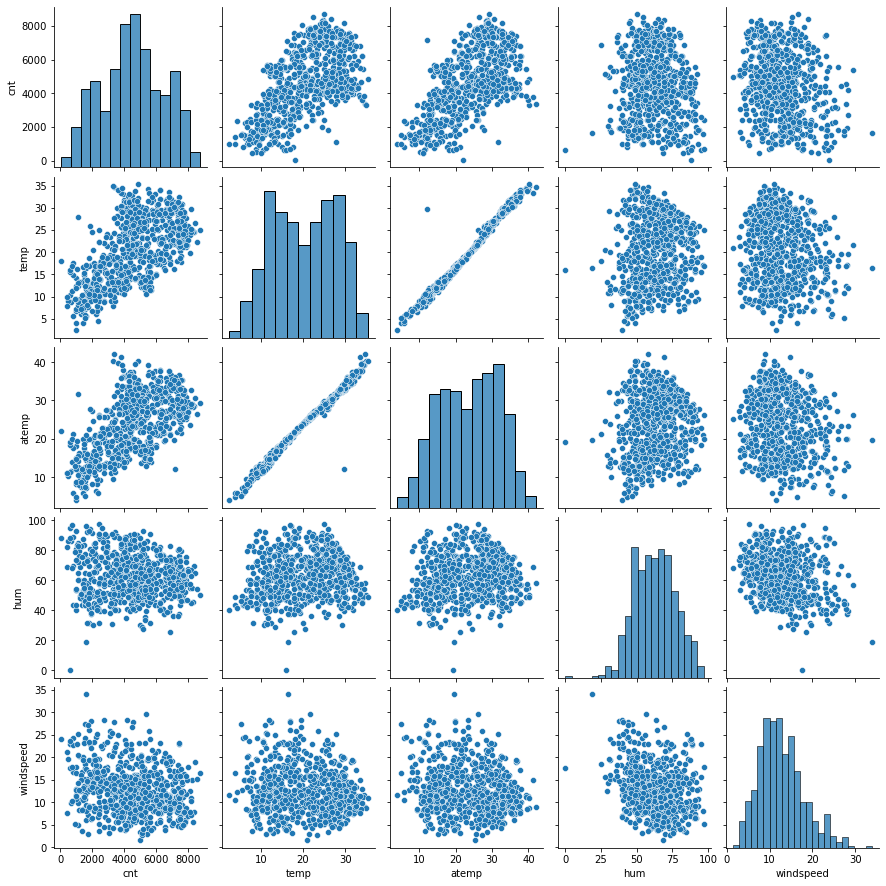

In [367]:
# let's look at realtionship with cnt for Numeric variables
sns.pairplot(Bikes[['cnt', 'temp', 'atemp', 'hum', 'windspeed']])
plt.show

### Observations:
    1. temp & atemp are very highly correlated, excepct for 1 outlier, can only use 1 of these in the model
    2. cnt shows positive relationship with temp/atemp
    3. weak realtionships with humidity & windspeed

<function matplotlib.pyplot.show(close=None, block=None)>

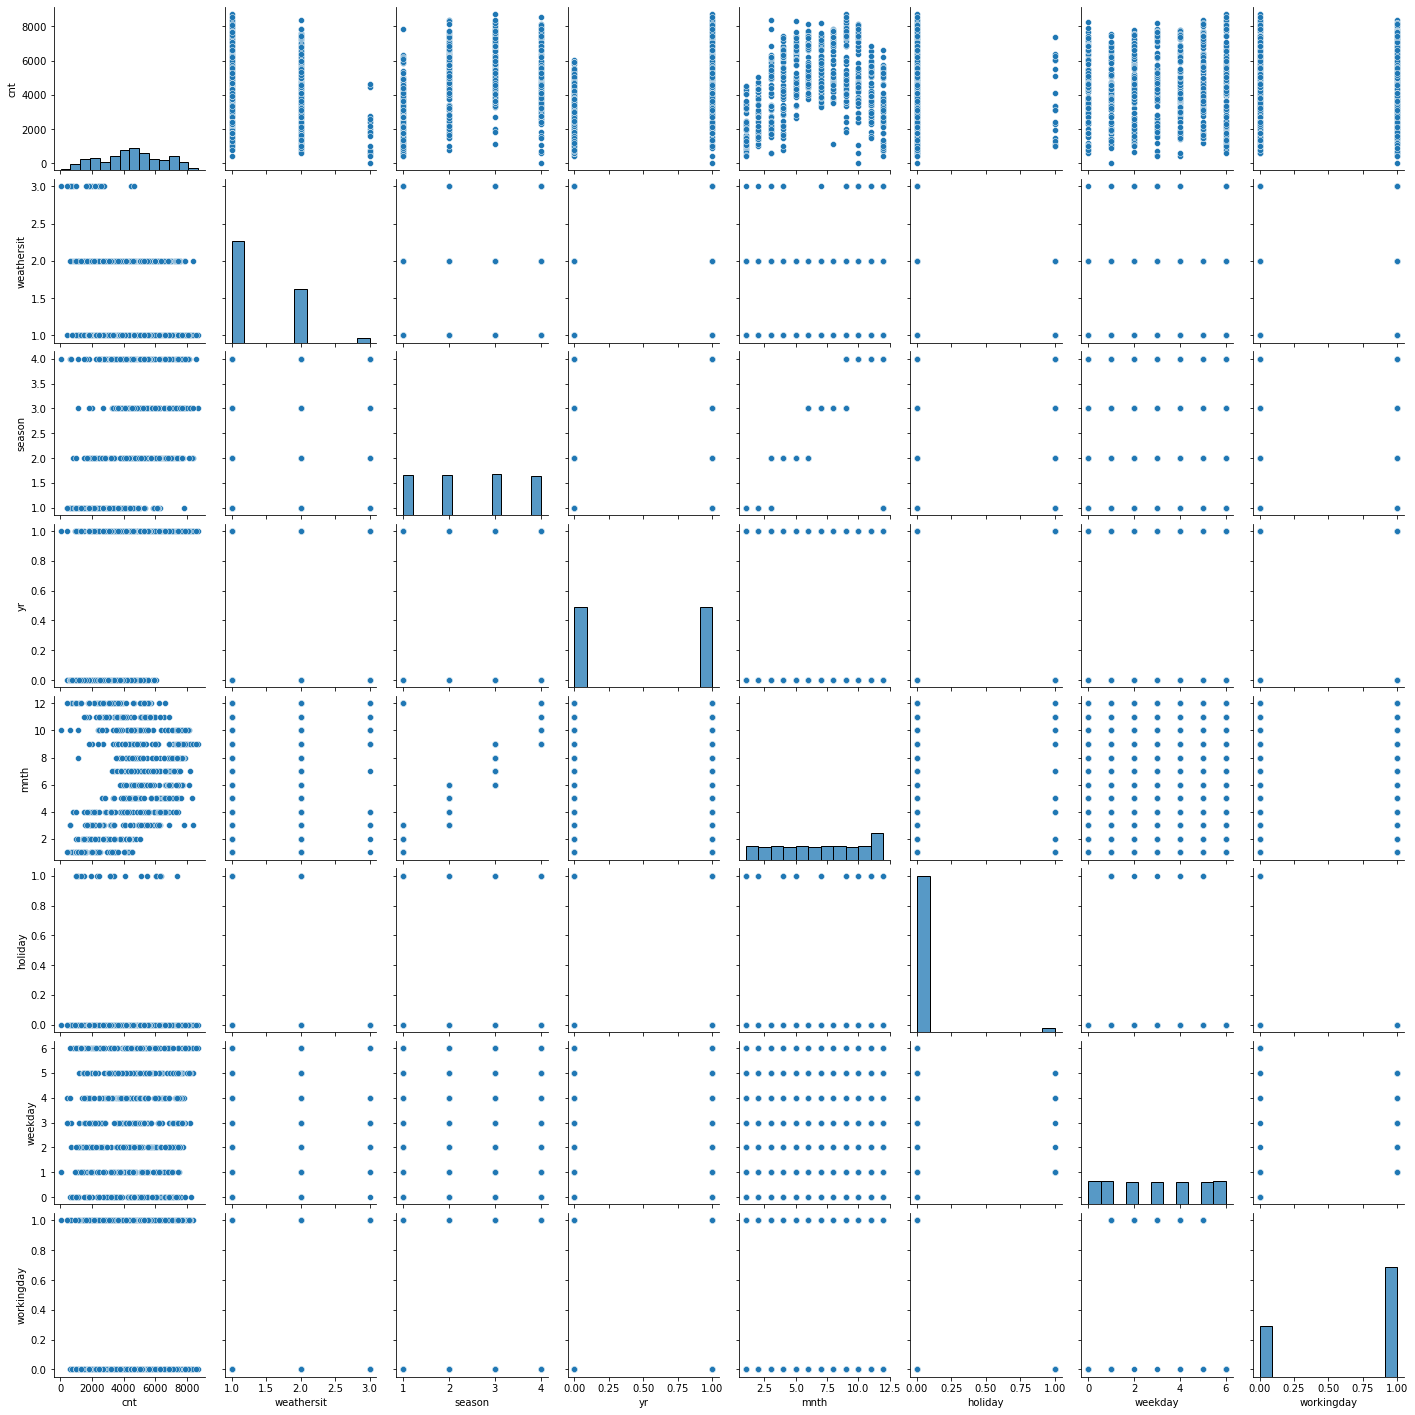

In [368]:
# let's look at realtionship with cnt for categorical variables
sns.pairplot(Bikes[[ 'cnt', 'weathersit', 'season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday']])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

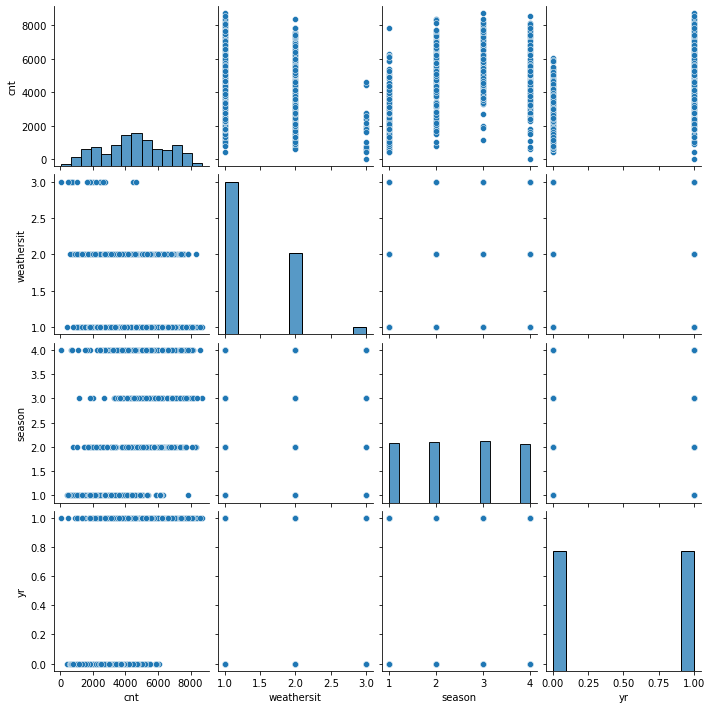

In [369]:
# Smmaler graphs to check relationship again
sns.pairplot(Bikes[[ 'cnt', 'weathersit','season', 'yr']])
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

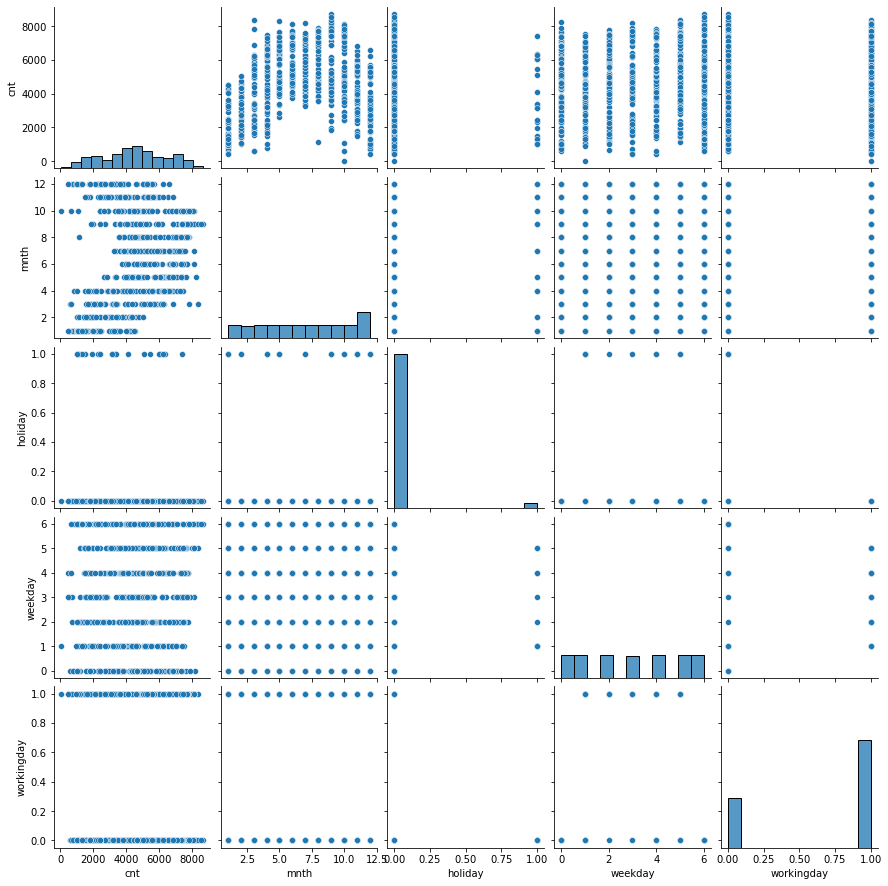

In [370]:

sns.pairplot(Bikes[[ 'cnt', 'mnth', 'holiday', 'weekday', 'workingday']])
plt.show

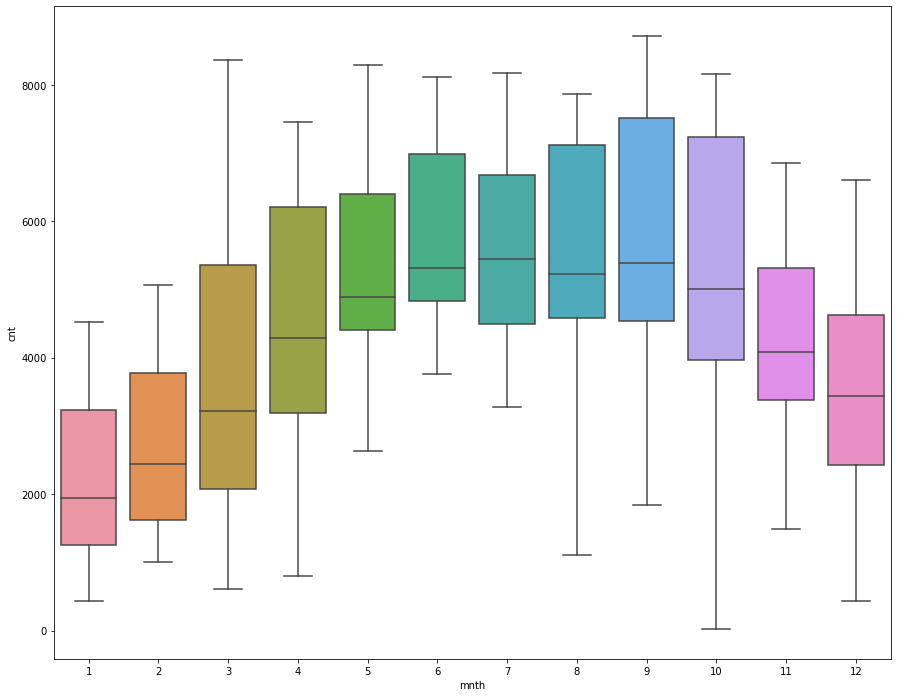

In [371]:
# Box Plot for cnt by mnth
plt.figure(figsize=(15, 12))
sns.boxplot(x='mnth', y='cnt', data = Bikes)
plt.show()

# There is a seasonal trend across the year, with cnt peaking around months 7,9 ...may correlate with good weather

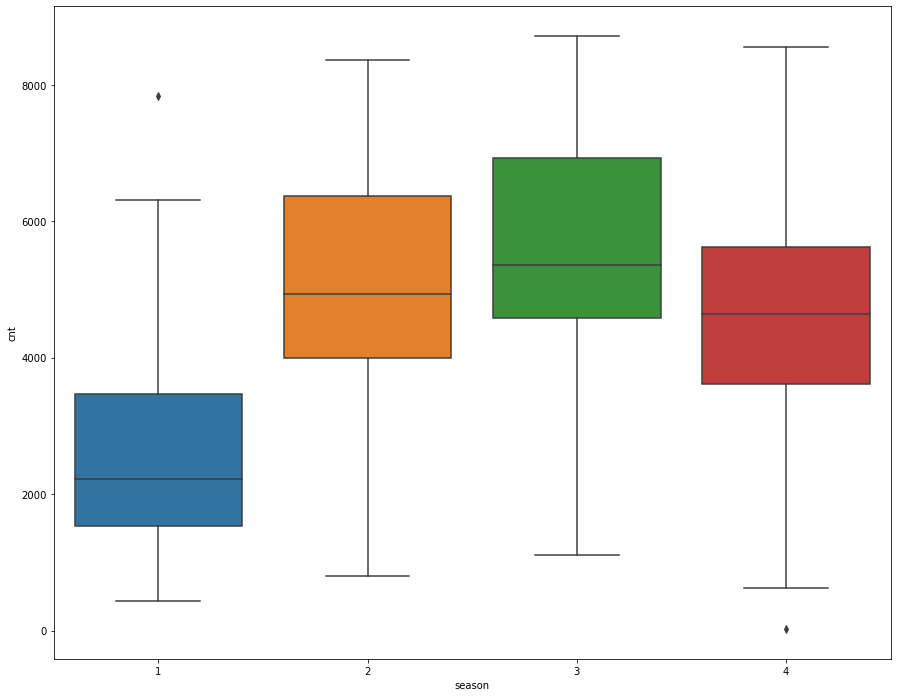

In [372]:
# Box Plot for cnt by season
plt.figure(figsize=(15, 12))
sns.boxplot(x='season', y='cnt', data = Bikes)
plt.show()

# Somewhat similar trend across seasons, when Pleasant more people take the bike. Highest cnt in 3= Fall

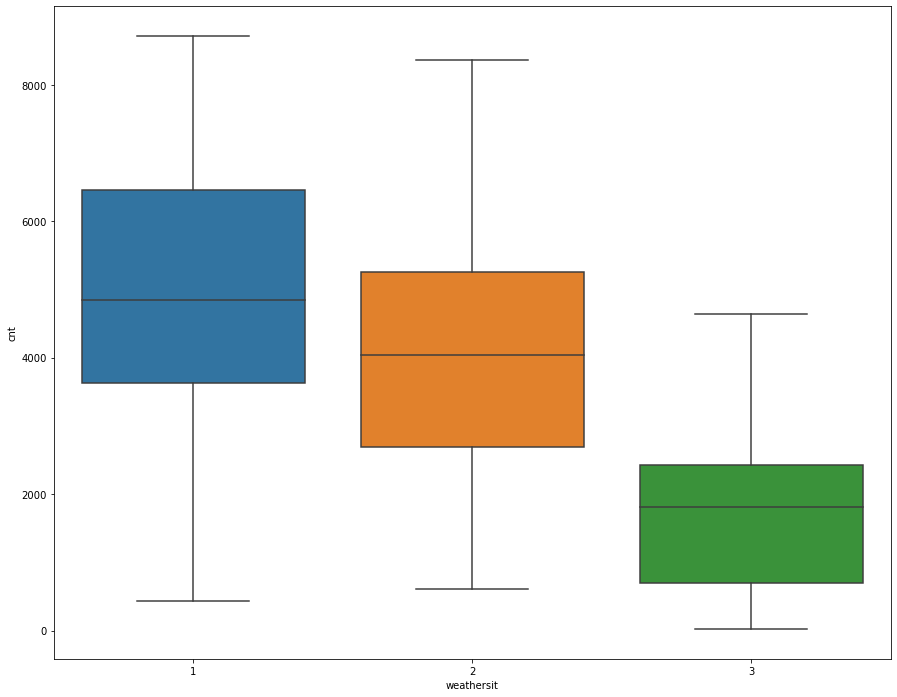

In [373]:
# Box Plot for cnt by weathersit
plt.figure(figsize=(15, 12))
sns.boxplot(x='weathersit', y='cnt', data = Bikes)
plt.show()

# Highest cnt in 1: Clear, Few clouds, Partly cloudy, Partly cloudy

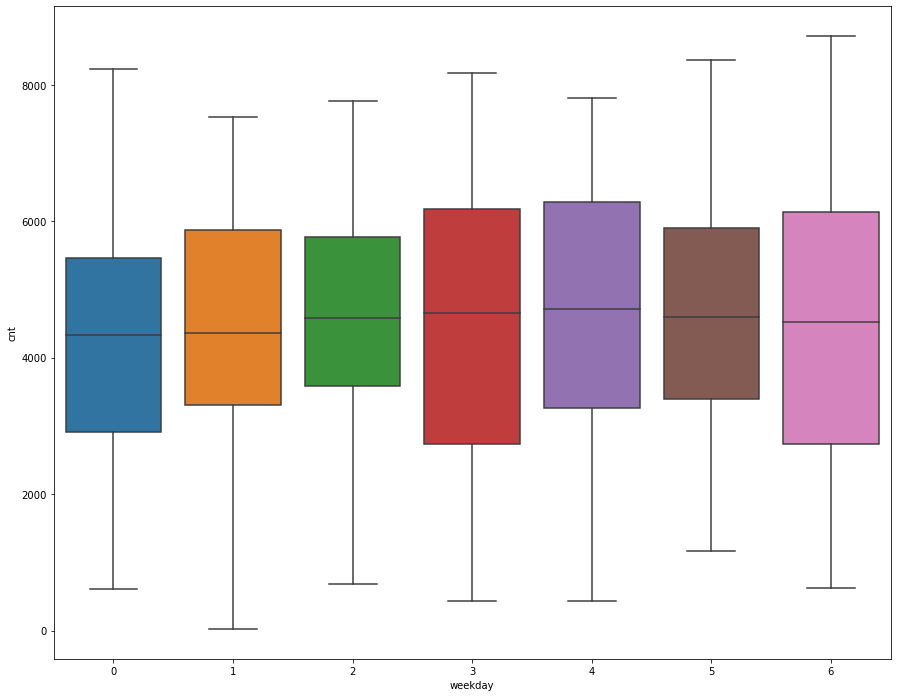

In [374]:
# Box Plot for cnt by weekday
plt.figure(figsize=(15, 12))
sns.boxplot(x='weekday', y='cnt', data = Bikes)
plt.show()

# Weekday doesn't show large enough variantion in median cnt, 3-4 marginally higher than rest

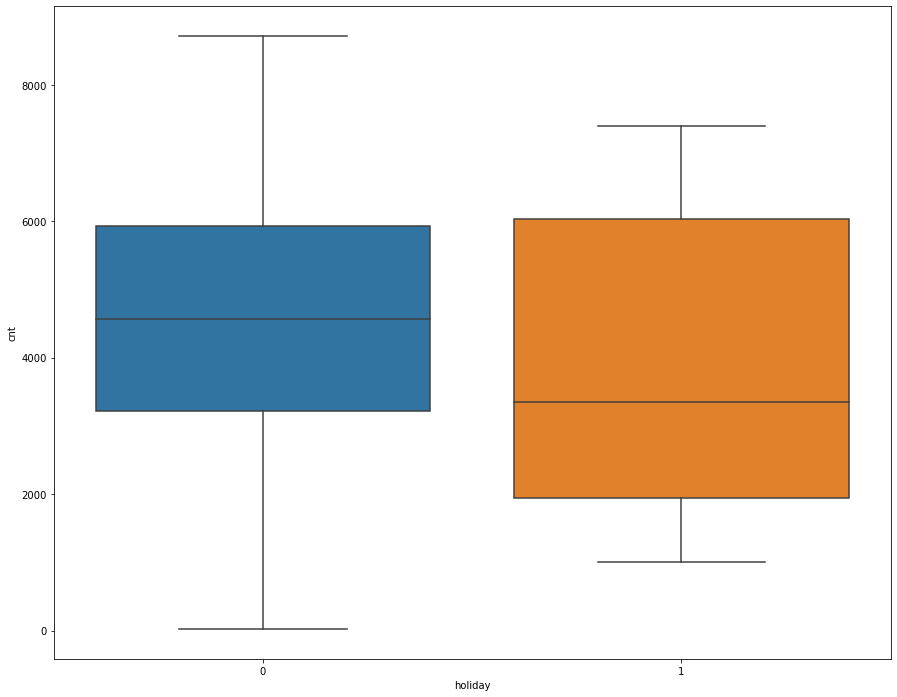

In [375]:
# Box Plot for cnt by holiday
plt.figure(figsize=(15, 12))
sns.boxplot(x='holiday', y='cnt', data = Bikes)
plt.show()

# Holiday corresonds to lower cnt than woking day as expected

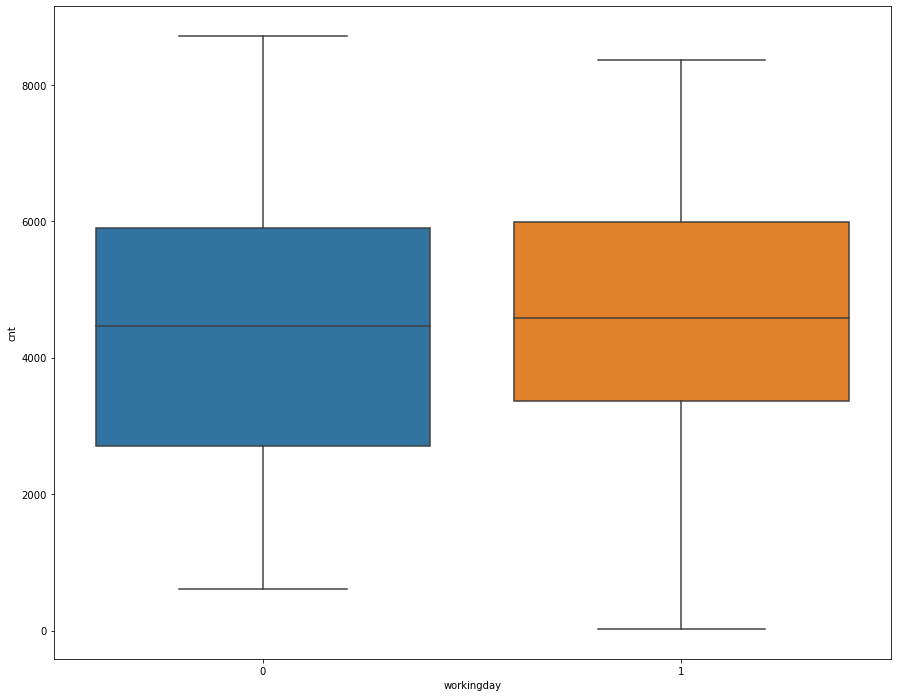

In [376]:
# Box Plot for cns by Workingday
plt.figure(figsize=(15, 12))
sns.boxplot(x='workingday', y='cnt', data = Bikes)
plt.show()


In [377]:
#onvert these to Charcater
Bikes['season'] = Bikes.season.astype(str)
Bikes['mnth'] = Bikes.mnth.astype(str)
Bikes['weekday'] = Bikes.weekday.astype(str)
Bikes['weathersit'] = Bikes.weathersit.astype(str)
Bikes[['season', 'mnth', 'weekday', 'weathersit']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   season      730 non-null    object
 1   mnth        730 non-null    object
 2   weekday     730 non-null    object
 3   weathersit  730 non-null    object
dtypes: object(4)
memory usage: 22.9+ KB


In [378]:
# Create Dummy variables for Categoricals
status = pd.get_dummies(Bikes[['season','mnth', 'weekday', 'weathersit']], drop_first=True)
status.head()

,season_2,season_3,season_4,mnth_10,mnth_11,mnth_12,mnth_2,mnth_3,mnth_4,mnth_5,...,mnth_8,mnth_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [379]:
# concat the dummy df to the base Bikes data

Bikes.info()
Bikes = pd.concat([Bikes, status], axis=1)
Bikes.head()
Bikes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      730 non-null    object 
 1   yr          730 non-null    int64  
 2   mnth        730 non-null    object 
 3   holiday     730 non-null    int64  
 4   weekday     730 non-null    object 
 5   workingday  730 non-null    int64  
 6   weathersit  730 non-null    object 
 7   temp        730 non-null    float64
 8   atemp       730 non-null    float64
 9   hum         730 non-null    float64
 10  windspeed   730 non-null    float64
 11  cnt         730 non-null    int64  
dtypes: float64(4), int64(4), object(4)
memory usage: 68.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 34 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   season        730 non-null    object 
 1   yr            730 n

In [380]:
#Drop the original vars where Dummy were created
Bikes.drop(columns=['season','mnth', 'weekday', 'weathersit'], inplace=True)
Bikes.info()
Bikes.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            730 non-null    int64  
 1   holiday       730 non-null    int64  
 2   workingday    730 non-null    int64  
 3   temp          730 non-null    float64
 4   atemp         730 non-null    float64
 5   hum           730 non-null    float64
 6   windspeed     730 non-null    float64
 7   cnt           730 non-null    int64  
 8   season_2      730 non-null    uint8  
 9   season_3      730 non-null    uint8  
 10  season_4      730 non-null    uint8  
 11  mnth_10       730 non-null    uint8  
 12  mnth_11       730 non-null    uint8  
 13  mnth_12       730 non-null    uint8  
 14  mnth_2        730 non-null    uint8  
 15  mnth_3        730 non-null    uint8  
 16  mnth_4        730 non-null    uint8  
 17  mnth_5        730 non-null    uint8  
 18  mnth_6        730 non-null    

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_8,mnth_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,0,0,...,0,0,0,0,0,0,0,1,1,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,0,0,...,0,0,0,0,1,0,0,0,0,0
5,0,0,1,8.378268,11.66045,51.8261,6.000868,1606,0,0,...,0,0,0,0,0,1,0,0,0,0
6,0,0,1,8.057402,10.44195,49.8696,11.304642,1510,0,0,...,0,0,0,0,0,0,1,0,1,0
7,0,0,0,6.765000,8.11270,53.5833,17.875868,959,0,0,...,0,0,0,0,0,0,0,1,1,0
8,0,0,0,5.671653,5.80875,43.4167,24.250650,822,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,1,6.184153,7.54440,48.2917,14.958889,1321,0,0,...,0,0,1,0,0,0,0,0,0,0


In [381]:
#test - train Split 80% for Training - 20% test

df_train, df_test = train_test_split(Bikes, train_size = 0.7, random_state = 100)
print(df_train.shape) 
print(df_test.shape) 

(510, 30)
(220, 30)


In [382]:
# using Min-max scaling to scale the numeric values

#1. Instantiate the Scaler
scaler = MinMaxScaler()

#create listr of numeric vars
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

#2. Deploy the Scaler
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])
df_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_8,mnth_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,1,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,0,0,...,0,0,0,0,0,0,0,1,1,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,0,0,...,0,0,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,1,0,...,0,0,0,0,0,0,0,1,1,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,1,0,...,0,0,0,0,0,0,1,0,1,0


In [383]:
#Check scaled values lie between 0 & 1
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_8,mnth_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.247059,0.262745,...,0.096078,0.080392,0.150980,0.131373,0.158824,0.133333,0.127451,0.154902,0.345098,0.029412
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.431725,0.440557,...,0.294988,0.272166,0.358381,0.338139,0.365870,0.340268,0.333805,0.362166,0.475867,0.169124
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


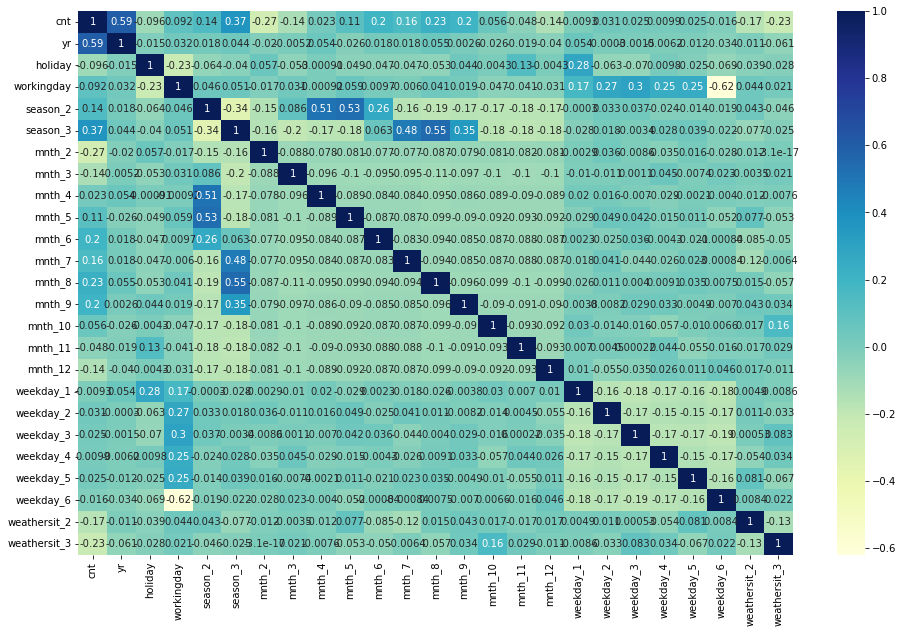

In [384]:
# Let's check the correlation coefficients to see which variables are highly correlated using a heatmap - part 1
plt.figure(figsize = (16, 10))
sns.heatmap(df_train[['cnt', 'yr', 'holiday', 'workingday', 'season_2', 'season_3', 'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8', 'mnth_9', 'mnth_10', 'mnth_11', 'mnth_12', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_2', 'weathersit_3']].corr(), annot = True, cmap = 'YlGnBu')
plt.show()

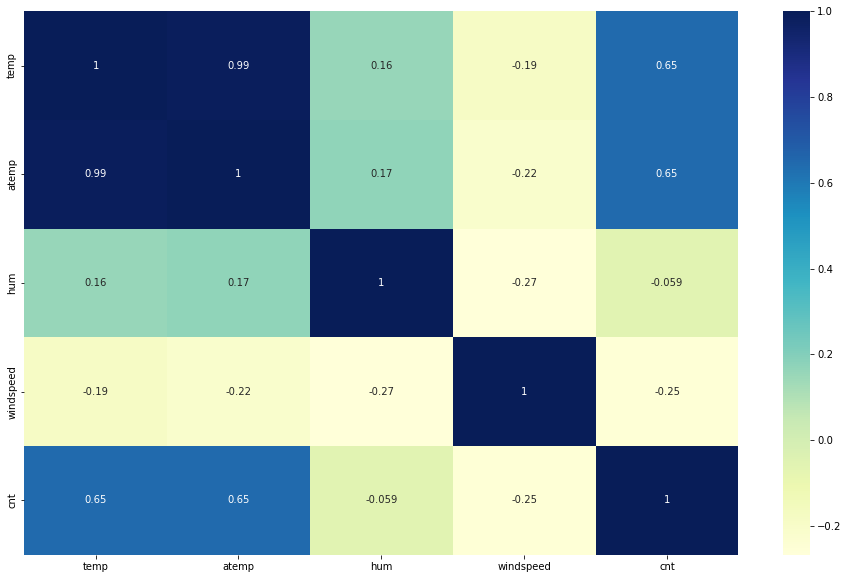

In [385]:
# Let's check the correlation coefficients to see which variables are highly correlated using a heatmap - part 2
plt.figure(figsize = (16, 10))
sns.heatmap(df_train[['temp','atemp', 'hum', 'windspeed', 'cnt']].corr(), annot = True, cmap = 'YlGnBu')
plt.show()

1. As noted earlier, very high collinearity for temp- atemp
2. cnt also correlated to both by R 65%
3. Amongst the dummy and categoricals
    - Moderately high corr. between season and month dummy variables, which shd be expected
    - Cnt & year 56%, cnt & season_3 35%


In [386]:
#Split the traing data into one with only independent and only dependent vars

y_train = df_train.pop('cnt') 
X_train = df_train 

X_train.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_2,season_3,season_4,...,mnth_8,mnth_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0,1,0,...,0,0,0,1,0,0,0,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0,0,0,...,0,0,0,0,0,0,0,1,1,0
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0,0,0,...,0,0,0,0,0,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,1,0,0,...,0,0,0,0,0,0,0,1,1,0
111,0,0,1,0.345824,0.318819,0.751824,0.380981,1,0,0,...,0,0,0,0,0,0,1,0,1,0


In [387]:
# Starting with a test Model with all the columns
X_train_sm = sm.add_constant(X_train)

#create the test model
lr = sm.OLS(y_train, X_train_sm)

#fit the test model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     99.37
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          2.81e-180
Time:                        20:44:57   Log-Likelihood:                 527.12
No. Observations:                 510   AIC:                            -996.2
Df Residuals:                     481   BIC:                            -873.4
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.1758      0.030      5.774      0.000       0.116       0.236
yr               0.2325      0.008     28.794      0.000       0.217       0.248
holiday         -0.0416      0.024     -1.758      0.079      -0.088       0.005
workingday       0.0438      0.009      4.666      0.000       0.025       0.062
temp             0.3880      0.142      2.727      0.007       0.108       0.668
atemp            0.0590      0.138      0.426      0.670      -0.213       0.331
hum             -0.1520      0.039     -3.938      0.000      -0.228      -0.076
windspeed       -0.1836      0.026     -6.962      0.000      -0.235      -0.132
season_2         0.0877      0.024      3.713      0.000       0.041       0.134
season_3         0.0454      0.030      1.511      0.131      -0.014       0.104
season_4         0.1524      0.026      5.866      0.000       0.101       0.203
mnth_10          0.0708      0.035      2.050      0.041       0.003       0.139
mnth_11          0.0232      0.033      0.707      0.480      -0.041       0.088
mnth_12          0.0188      0.027      0.708      0.479      -0.033       0.071
mnth_2           0.0307      0.021      1.489      0.137      -0.010       0.071
mnth_3           0.0646      0.022      2.886      0.004       0.021       0.109
mnth_4           0.0631      0.034      1.876      0.061      -0.003       0.129
mnth_5           0.0886      0.036      2.446      0.015       0.017       0.160
mnth_6           0.0691      0.039      1.776      0.076      -0.007       0.145
mnth_7           0.0304      0.044      0.692      0.489      -0.056       0.117
mnth_8           0.0853      0.042      2.038      0.042       0.003       0.168
mnth_9           0.1498      0.037      4.006      0.000       0.076       0.223
weekday_1       -0.0101      0.010     -1.033      0.302      -0.029       0.009
weekday_2       -0.0069      0.011     -0.616      0.538      -0.029       0.015
weekday_3        0.0057      0.011      0.538      0.591      -0.015       0.026
weekday_4        0.0018      0.011      0.168      0.867      -0.020       0.023
weekday_5        0.0116      0.011      1.029      0.304      -0.011       0.034
weekday_6        0.0542      0.015      3.729      0.000       0.026       0.083
weathersit_2    -0.0595      0.010     -5.701      0.000      -0.080      -0.039
weathersit_3    -0.2550      0.026     -9.631      0.000      -0.307      -0.203
==============================================================================
Omnibus:                       84.490   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              234.656
Skew:                          -0.805   Prob(JB):                     1.11e-51
Kurtosis:                       5.907   Cond. No.                     1.07e+16
===============

### With all vars although pretty good R.sq & adj. R.sq. There are a lot of vars which are not significant. 
### So we should go for feature elimination using VIF & RFE.

#### Looking at individual var P-value & whole model P-value(using F-Stat), form odel significance

In [388]:
# Check VIF values, shd be very high as there were a lot of collinear vars
vif = pd.DataFrame()

vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)

vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
24,weekday_4,inf
22,weekday_2,inf
1,holiday,inf
23,weekday_3,inf
25,weekday_5,inf
21,weekday_1,inf
2,workingday,inf
3,temp,446.42
4,atemp,383.20
5,hum,20.80


In [389]:
# RFE with 15 features
lm = LinearRegression()
rfe1 = RFE(lm, 15)

# Fit with 15 features
rfe1.fit(X_train, y_train)

# Print the results
rfe2 = pd.DataFrame()

rfe2['columns'] = X_train.columns
rfe2['suppport'] = rfe1.support_
rfe2['ranking'] = rfe1.ranking_
rfe2

,columns,suppport,ranking
0,yr,True,1
1,holiday,True,1
2,workingday,True,1
3,temp,True,1
4,atemp,False,6
5,hum,True,1
6,windspeed,True,1
7,season_2,True,1
8,season_3,True,1
9,season_4,True,1


In [390]:
# let's reduce to 10 features only 
# RFE with 10 features only

lm = LinearRegression()
rfe1 = RFE(lm, 10)

# Fit with 15 features
rfe1.fit(X_train, y_train)

# Print the results
rfe2 = pd.DataFrame()

rfe2['columns'] = X_train.columns
rfe2['suppport'] = rfe1.support_
rfe2['ranking'] = rfe1.ranking_
rfe2

,columns,suppport,ranking
0,yr,True,1
1,holiday,True,1
2,workingday,False,4
3,temp,True,1
4,atemp,False,11
5,hum,True,1
6,windspeed,True,1
7,season_2,True,1
8,season_3,False,6
9,season_4,True,1


In [391]:
X_train.columns

Index(['yr', 'holiday', 'workingday', 'temp', 'atemp', 'hum', 'windspeed',
       'season_2', 'season_3', 'season_4', 'mnth_10', 'mnth_11', 'mnth_12',
       'mnth_2', 'mnth_3', 'mnth_4', 'mnth_5', 'mnth_6', 'mnth_7', 'mnth_8',
       'mnth_9', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4',
       'weekday_5', 'weekday_6', 'weathersit_2', 'weathersit_3'],
      dtype='object')

In [393]:
# Keeping only the 10 columns per RFE based selection

X_train = X_train[['yr', 'holiday', 'temp', 'hum', 'windspeed', 'season_2', 'season_4', 'mnth_8', 'mnth_9', 'weathersit_3']]
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 510 entries, 576 to 520
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   yr            510 non-null    int64  
 1   holiday       510 non-null    int64  
 2   temp          510 non-null    float64
 3   hum           510 non-null    float64
 4   windspeed     510 non-null    float64
 5   season_2      510 non-null    uint8  
 6   season_4      510 non-null    uint8  
 7   mnth_8        510 non-null    uint8  
 8   mnth_9        510 non-null    uint8  
 9   weathersit_3  510 non-null    uint8  
dtypes: float64(3), int64(2), uint8(5)
memory usage: 26.4 KB


### Model no. 1 after RFE

In [394]:
X_train_sm = sm.add_constant(X_train)

#create the first model
lr = sm.OLS(y_train, X_train_sm)

#fit the first model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.833
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     248.8
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          1.02e-186
Time:                        20:54:38   Log-Likelihood:                 495.21
No. Observations:                 510   AIC:                            -968.4
Df Residuals:                     499   BIC:                            -921.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.2755      0.026     10.547      0.000       0.224       0.327
yr               0.2264      0.008     27.262      0.000       0.210       0.243
holiday         -0.0893      0.026     -3.409      0.001      -0.141      -0.038
temp             0.5660      0.022     25.833      0.000       0.523       0.609
hum             -0.2848      0.032     -9.026      0.000      -0.347      -0.223
windspeed       -0.2012      0.026     -7.729      0.000      -0.252      -0.150
season_2         0.1011      0.011      9.084      0.000       0.079       0.123
season_4         0.1508      0.011     13.840      0.000       0.129       0.172
mnth_8           0.0496      0.017      2.973      0.003       0.017       0.082
mnth_9           0.1190      0.017      7.174      0.000       0.086       0.152
weathersit_3    -0.1916      0.026     -7.496      0.000      -0.242      -0.141
==============================================================================
Omnibus:                       56.891   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              105.867
Skew:                          -0.673   Prob(JB):                     1.03e-23
Kurtosis:                       4.781   Cond. No.                         15.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [395]:
# Check VIF values again
vif = pd.DataFrame()

vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)

vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
3,hum,10.02
2,temp,8.52
4,windspeed,3.57
0,yr,2.01
5,season_2,1.82
6,season_4,1.73
7,mnth_8,1.57
8,mnth_9,1.30
9,weathersit_3,1.09
1,holiday,1.04


### Notes on Model 1:

1. Pretty good in terms of R.Sq & adj. R. Sq
2. We still have high VIF values, the higher coeff. for temp suggest it is more important 
3. So let's drop hum(humidity) & see if VIF improves

### Model no. 2 drop humidity

In [396]:
X_train.drop(columns=['hum'],inplace=True)

# Check VIF values again
vif = pd.DataFrame()

vif['Features'] = X_train.columns
vif['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
vif['VIF'] = round(vif['VIF'], 2)

vif = vif.sort_values(by = 'VIF', ascending = False)
vif

,Features,VIF
2,temp,4.99
3,windspeed,3.01
0,yr,2.00
4,season_2,1.79
6,mnth_8,1.57
5,season_4,1.44
7,mnth_9,1.29
8,weathersit_3,1.06
1,holiday,1.04


In [397]:
X_train_sm = sm.add_constant(X_train)

#create the first model
lr = sm.OLS(y_train, X_train_sm)

#fit the first model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     230.3
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          1.39e-171
Time:                        20:55:16   Log-Likelihood:                 456.65
No. Observations:                 510   AIC:                            -893.3
Df Residuals:                     500   BIC:                            -851.0
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0900      0.017      5.181      0.000       0.056       0.124
yr               0.2332      0.009     26.169      0.000       0.216       0.251
holiday         -0.0848      0.028     -3.005      0.003      -0.140      -0.029
temp             0.5464      0.023     23.262      0.000       0.500       0.593
windspeed       -0.1427      0.027     -5.252      0.000      -0.196      -0.089
season_2         0.0905      0.012      7.588      0.000       0.067       0.114
season_4         0.1316      0.012     11.430      0.000       0.109       0.154
mnth_8           0.0394      0.018      2.196      0.029       0.004       0.075
mnth_9           0.1002      0.018      5.650      0.000       0.065       0.135
weathersit_3    -0.2520      0.027     -9.483      0.000      -0.304      -0.200
==============================================================================
Omnibus:                       63.117   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              111.174
Skew:                          -0.757   Prob(JB):                     7.23e-25
Kurtosis:                       4.714   Cond. No.                         9.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [398]:
# Print intercept & beta coeff. 
lr_model.params

const           0.090030
yr              0.233233
holiday        -0.084826
temp            0.546436
windspeed      -0.142707
season_2        0.090521
season_4        0.131612
mnth_8          0.039352
mnth_9          0.100173
weathersit_3   -0.251998
dtype: float64

### Check residuals

<AxesSubplot:ylabel='Density'>

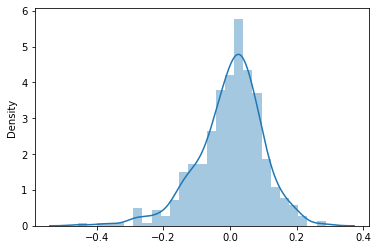

In [399]:
y_train_pred = lr_model.predict(X_train_sm)
res = y_train - y_train_pred
sns.distplot(res)

# Very Nice Normal plot, looks good to me

### Check the model on Test data

In [400]:
#create list of numeric vars
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

#2. Deploy the Scaler
df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_2,season_3,...,mnth_8,mnth_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,1,...,0,0,1,0,0,0,0,0,1,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,1,0,...,0,0,0,0,1,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,0,0,0,0,0,1,0,0,1,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,1,...,1,0,0,0,1,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,1,0,...,0,0,0,0,0,1,0,0,0,0


In [401]:
y_test = df_test.pop('cnt')
X_test = df_test

In [402]:
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,yr,holiday,workingday,temp,atemp,hum,windspeed,season_2,season_3,...,mnth_8,mnth_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
184,1.0,0,1,0,0.831783,0.769660,0.657364,0.084219,0,1,...,0,0,1,0,0,0,0,0,1,0
535,1.0,1,0,1,0.901354,0.842587,0.610133,0.153728,1,0,...,0,0,0,0,1,0,0,0,0,0
299,1.0,0,0,1,0.511964,0.496145,0.837699,0.334206,0,0,...,0,0,0,0,0,1,0,0,1,0
221,1.0,0,0,1,0.881625,0.795343,0.437098,0.339570,0,1,...,1,0,0,0,1,0,0,0,0,0
152,1.0,0,0,1,0.817246,0.741471,0.314298,0.537414,1,0,...,0,0,0,0,0,1,0,0,0,0


In [404]:
#Make predictions on test using model

X_test_sm = X_test_sm[['const','yr','holiday', 'temp', 'windspeed', 'season_2', 'season_4', 'mnth_8', 'mnth_9', 'weathersit_3']]

y_test_pred = lr_model.predict(X_test_sm)

In [405]:
# Evaluate

r2_score(y_true = y_test, y_pred = y_test_pred)

0.7731388699761521

### R Square on Test data is : 0.7731 
###                          Vs
### R Square on Train data of : 0.806 (0.802 Adj R. Sq)

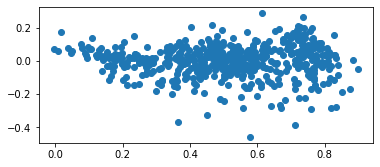

In [410]:
# Plotting Residuals to check Homoscedascity

fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_train_pred, res)

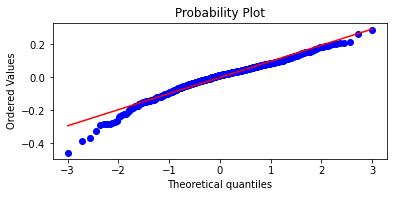

In [412]:
# Plotting QQ plot to check model
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(res, plot=ax, fit=True)

### Observations
1. The residual scatter plot suggests, that although normally distributed the errors seems to form the fan pattern
2. The spread in errors increase as y_pred increases

3. The QQ plot also shows devaition from the line at extremes

- Better models are clearly possible that may improve upon these, maybe at the cost of R Square

### Model no. 3 drop month 8

In [414]:
X_train.drop(columns=['mnth_8'],inplace=True)

X_train_sm = sm.add_constant(X_train)

#create the first model
lr = sm.OLS(y_train, X_train_sm)

#fit the first model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     256.6
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          9.22e-172
Time:                        21:21:04   Log-Likelihood:                 454.20
No. Observations:                 510   AIC:                            -890.4
Df Residuals:                     501   BIC:                            -852.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0875      0.017      5.029      0.000       0.053       0.122
yr               0.2334      0.009     26.093      0.000       0.216       0.251
holiday         -0.0867      0.028     -3.060      0.002      -0.142      -0.031
temp             0.5682      0.021     26.580      0.000       0.526       0.610
windspeed       -0.1455      0.027     -5.340      0.000      -0.199      -0.092
season_2         0.0812      0.011      7.256      0.000       0.059       0.103
season_4         0.1261      0.011     11.179      0.000       0.104       0.148
mnth_9           0.0895      0.017      5.229      0.000       0.056       0.123
weathersit_3    -0.2535      0.027     -9.506      0.000      -0.306      -0.201
==============================================================================
Omnibus:                       62.269   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.317
Skew:                          -0.761   Prob(JB):                     8.20e-24
Kurtosis:                       4.640   Cond. No.                         9.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [415]:
### Model no. 4 drop holiday

X_train.drop(columns=['holiday'],inplace=True)

X_train_sm = sm.add_constant(X_train)

#create the first model
lr = sm.OLS(y_train, X_train_sm)

#fit the first model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     287.1
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          5.34e-171
Time:                        21:22:13   Log-Likelihood:                 449.48
No. Observations:                 510   AIC:                            -883.0
Df Residuals:                     502   BIC:                            -849.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0839      0.018      4.790      0.000       0.049       0.118
yr               0.2337      0.009     25.908      0.000       0.216       0.251
temp             0.5719      0.022     26.576      0.000       0.530       0.614
windspeed       -0.1474      0.027     -5.366      0.000      -0.201      -0.093
season_2         0.0824      0.011      7.317      0.000       0.060       0.105
season_4         0.1251      0.011     11.004      0.000       0.103       0.147
mnth_9           0.0868      0.017      5.035      0.000       0.053       0.121
weathersit_3    -0.2502      0.027     -9.314      0.000      -0.303      -0.197
==============================================================================
Omnibus:                       64.591   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.216
Skew:                          -0.778   Prob(JB):                     4.29e-25
Kurtosis:                       4.691   Cond. No.                         9.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### We don't see a vast improvemnt by dropping holiday, but it is a variable that 
### will aid inference and has a negative impact on cnt

In [420]:
X_train['holiday'] =  df_train['holiday']

In [421]:
X_train

,yr,temp,windspeed,season_2,season_4,mnth_9,weathersit_3,holiday
576,1,0.815169,0.264686,0,0,0,0,0
426,1,0.442393,0.255342,0,0,0,0,0
728,1,0.245101,0.663106,0,0,0,0,0
482,1,0.395666,0.188475,1,0,0,0,0
111,0,0.345824,0.380981,1,0,0,0,0
...,...,...,...,...,...,...,...,...
578,1,0.863973,0.187140,0,0,0,0,0
53,0,0.202618,0.111379,0,0,0,0,0
350,0,0.248216,0.431816,0,1,0,0,0
79,0,0.462664,0.529881,1,0,0,0,0


In [422]:
# Sticking to Model # 3 and testing results

X_train_sm = sm.add_constant(X_train)

#create the first model
lr = sm.OLS(y_train, X_train_sm)

#fit the first model
lr_model = lr.fit()
lr_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.804
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     256.6
Date:                Wed, 14 Sep 2022   Prob (F-statistic):          9.22e-172
Time:                        21:29:03   Log-Likelihood:                 454.20
No. Observations:                 510   AIC:                            -890.4
Df Residuals:                     501   BIC:                            -852.3
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0875      0.017      5.029      0.000       0.053       0.122
yr               0.2334      0.009     26.093      0.000       0.216       0.251
temp             0.5682      0.021     26.580      0.000       0.526       0.610
windspeed       -0.1455      0.027     -5.340      0.000      -0.199      -0.092
season_2         0.0812      0.011      7.256      0.000       0.059       0.103
season_4         0.1261      0.011     11.179      0.000       0.104       0.148
mnth_9           0.0895      0.017      5.229      0.000       0.056       0.123
weathersit_3    -0.2535      0.027     -9.506      0.000      -0.306      -0.201
holiday         -0.0867      0.028     -3.060      0.002      -0.142      -0.031
==============================================================================
Omnibus:                       62.269   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              106.317
Skew:                          -0.761   Prob(JB):                     8.20e-24
Kurtosis:                       4.640   Cond. No.                         9.78
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [435]:
X_test

,yr,holiday,workingday,temp,atemp,hum,windspeed,season_2,season_3,season_4,...,mnth_8,mnth_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0,1,0,...,0,0,1,0,0,0,0,0,1,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,1,0,0,...,0,0,0,0,1,0,0,0,0,0
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0,0,1,...,0,0,0,0,0,1,0,0,1,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0,1,0,...,1,0,0,0,1,0,0,0,0,0
152,0,0,1,0.817246,0.741471,0.314298,0.537414,1,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
702,1,0,1,0.519232,0.511907,0.756118,0.283397,0,0,1,...,0,0,0,1,0,0,0,0,0,0
127,0,0,0,0.584649,0.577380,0.650923,0.069510,1,0,0,...,0,0,0,0,0,0,0,0,0,0
640,1,0,1,0.745598,0.682653,0.817947,0.052115,0,0,1,...,0,0,0,0,1,0,0,0,1,0
72,0,0,1,0.331557,0.332005,0.512107,0.203418,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [439]:
X_test_sm = sm.add_constant(X_test)
X_test_sm.head()

,const,yr,holiday,workingday,temp,atemp,hum,windspeed,season_2,season_3,...,mnth_8,mnth_9,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
184,1.0,0,1,0,0.831783,0.769660,0.657364,0.084219,0,1,...,0,0,1,0,0,0,0,0,1,0
535,1.0,1,0,1,0.901354,0.842587,0.610133,0.153728,1,0,...,0,0,0,0,1,0,0,0,0,0
299,1.0,0,0,1,0.511964,0.496145,0.837699,0.334206,0,0,...,0,0,0,0,0,1,0,0,1,0
221,1.0,0,0,1,0.881625,0.795343,0.437098,0.339570,0,1,...,1,0,0,0,1,0,0,0,0,0
152,1.0,0,0,1,0.817246,0.741471,0.314298,0.537414,1,0,...,0,0,0,0,0,1,0,0,0,0


In [440]:
#Make predictions on test using model

X_test_sm = X_test_sm[['const','yr', 'temp', 'windspeed', 'season_2', 'season_4','mnth_9', 'weathersit_3', 'holiday']]

y_test_pred = lr_model.predict(X_test_sm)

In [443]:
# Evaluate Rsquare on test data

r2_score(y_true = y_test, y_pred = y_test_pred)

0.7720731949554799

<AxesSubplot:ylabel='Density'>

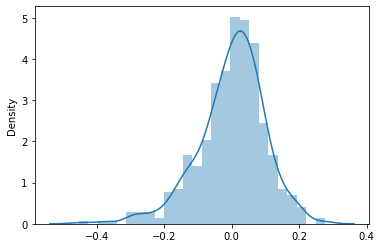

In [444]:
#Compute Residuals & plot

y_train_pred = lr_model.predict(X_train_sm)
res = y_train - y_train_pred
sns.distplot(res)

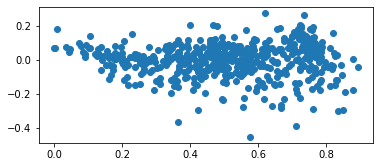

In [445]:
# Plotting Residuals to check Homoscedascity

fig, ax = plt.subplots(figsize=(6,2.5))
_ = ax.scatter(y_train_pred, res)

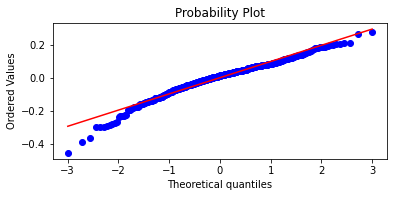

In [446]:
# Plotting QQ plot to check model
fig, ax = plt.subplots(figsize=(6,2.5))
_, (__, ___, r) = sp.stats.probplot(res, plot=ax, fit=True)

In [449]:
lr_model.params

const           0.087528
yr              0.233434
temp            0.568212
windspeed      -0.145477
season_2        0.081150
season_4        0.126067
mnth_9          0.089499
weathersit_3   -0.253491
holiday        -0.086667
dtype: float64

In [452]:
param1 = pd.DataFrame()

param1['coeff'] = lr_model.params

param1 = param1.sort_values(by = 'coeff', ascending = False)
param1

,coeff
temp,0.568212
yr,0.233434
season_4,0.126067
mnth_9,0.089499
const,0.087528
season_2,0.081150
holiday,-0.086667
windspeed,-0.145477
weathersit_3,-0.253491


### Final model notes:
What does the Model mean ?

1.  `temp`: too high or tooo low temps will make it hard to cycle and drive lowere rentals
2. weathersit_3 : corresponding to `Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds`. Poor weather leads to lower rentals
3. yr  'year (0: 2018, 1:2019)': As 2019 is coded as 1, indicates far higher rentals in 2019. What led to it the Owners may better explain, assuming the service ws more well known and more available in 2019 than 2018.
4. Some other weather related variables too: `season_4, season_2, mnth_9, windspeed`
    Negative windspeed here means ther higer winds men lower rentals.

So Far weather remains the most important determinant in Bike rentals, all these have been weather related/proxy variables

5. `Holiday`: the only non weather variable, we saw it was just about significant. We have very few cases in the data with holidays. The negaative coeff. indicates that Holidays mean lower demand.

P.S. Rentals == Share